In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import seaborn as sns
from matplotlib import pyplot as plt

Text(0.5, 0, 'Pay')

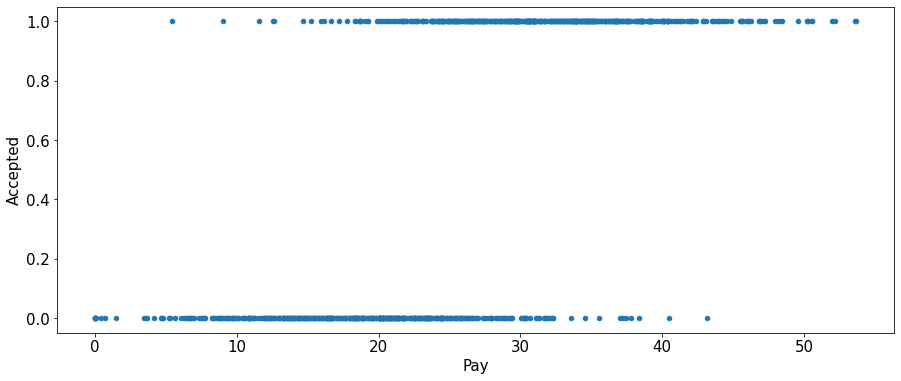

In [2]:
month_1 = pd.read_csv('driverAcceptanceData.csv')
month_1 = month_1.drop('Unnamed: 0', axis=1)
month_1.plot(x='PAY',y='ACCEPTED', kind='scatter', figsize=(15,6), fontsize=15)
plt.ylabel('Accepted', fontsize=15)
plt.xlabel('Pay', fontsize=15)

<AxesSubplot:ylabel='Frequency'>

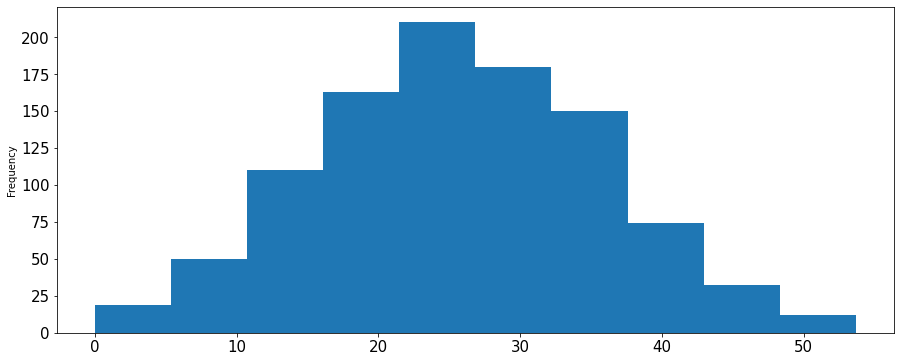

In [3]:
month_1['PAY'].plot(kind='hist', figsize=(15,6), fontsize=15)

This histogram shows that the distribution for the payment for all proposed rides follows a normal distribution.

<AxesSubplot:ylabel='Frequency'>

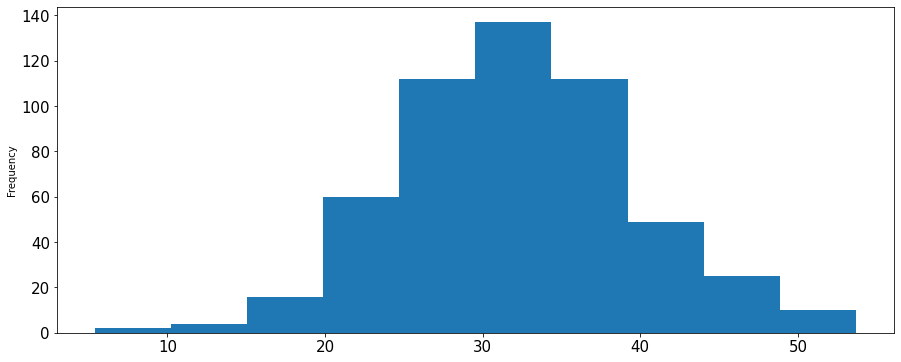

In [4]:
month_1[month_1["ACCEPTED"]==1]["PAY"].plot(kind='hist', figsize=(15,6), fontsize=15)

This histogram shows that the distribution for the payment for accepted rides follows a normal distribution with a mean close to $32. 

<AxesSubplot:ylabel='Frequency'>

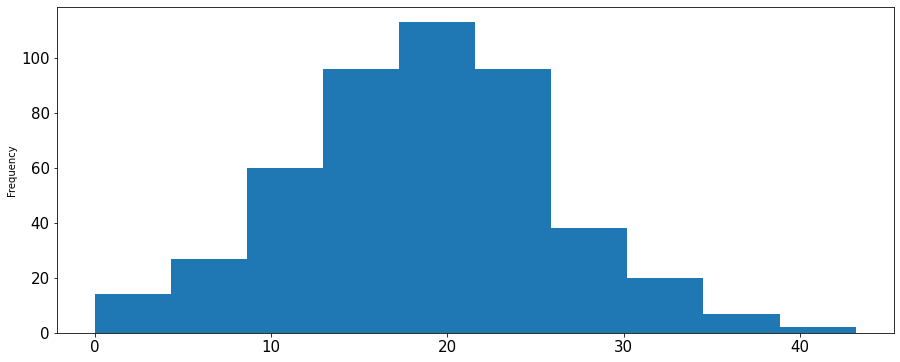

In [5]:
month_1[month_1["ACCEPTED"]==0]["PAY"].plot(kind='hist', figsize=(15,6), fontsize=15)

This histogram shows that the proposed payment for rides that were denied follows a normal distribution with a mean close to $20. 

In [6]:
month_1['Profit Margin'] = (30-month_1['PAY'])*month_1['ACCEPTED']

The profit margin made from each ride is \\$30 minus the proposed payment to the driver and is only made if the ride is actually accepted.

In [7]:
month_1['Profit Margin'].sum()

-1094.0771378079999

The business is making a loss of about a thousand in its first month with this current pricing.

<AxesSubplot:xlabel='PAY', ylabel='ACCEPTED'>

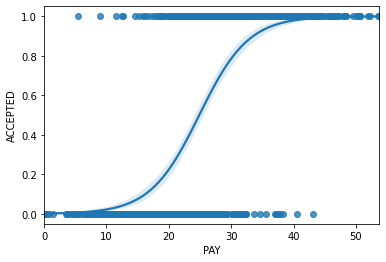

In [8]:
from sklearn.linear_model import LogisticRegression

X = np.array([month_1["PAY"]]).reshape(-1,1)
y = np.array([month_1['ACCEPTED']]).ravel()
model = LogisticRegression().fit(X, y)
sns.regplot(x='PAY', y="ACCEPTED", data=month_1, logistic=True)

Considering this is a binary classification task, a logistic regressor is appropriate. It seems that $25 is around the mark where the probability of a ride being accepted based on tha payment is 50/50. Various amounts can be input into the logistic regressor that has been trained with the 1st month's data and the probability of acceptance will be displayed. 

In [9]:
for i in range(20,35):
    print(f'${i}:{model.predict_proba([[i]])}')

$20:[[0.77525228 0.22474772]]
$21:[[0.72798244 0.27201756]]
$22:[[0.67493924 0.32506076]]
$23:[[0.61699452 0.38300548]]
$24:[[0.55552286 0.44447714]]
$25:[[0.49230346 0.50769654]]
$26:[[0.42932925 0.57067075]]
$27:[[0.36856265 0.63143735]]
$28:[[0.31169911 0.68830089]]
$29:[[0.25999636 0.74000364]]
$30:[[0.21420084 0.78579916]]
$31:[[0.17456881 0.82543119]]
$32:[[0.14095427 0.85904573]]
$33:[[0.11292693 0.88707307]]
$34:[[0.0898894 0.9101106]]


The 2nd column in the output list is the probablity that the driver will accept the rider based on the payment. \\$25 is indeed the payment for which the probability of a driver accepting is 50/50. \\$29 is where it is about 74% likely that a driver will accept. At \\$34, the driver is 91\% likely to accept. The objective is to maximize the difference between the \\$30 flat fee for the rider and the payout to the driver as well as onboard as many customers as possible in order to get more profitable rides, assuming the \\$30 onboarding fee is forgone.  

In [10]:
total_profit = [month_1['Profit Margin'].sum()]
np.random.seed(5)
def simulator(previous_month, new_cust):
    rides_from_new_cust = sum(np.random.poisson(1, new_cust))
    requested_rides = np.random.poisson(len(previous_month[previous_month["ACCEPTED"]==1]),1)
    requested_rides += rides_from_new_cust
    df = pd.DataFrame()
    df['PAY'] = np.random.uniform(25, 29, requested_rides[0])
    df['ACCEPTED'] = model.predict(np.array([df["PAY"]]).reshape(-1, 1))
    df['Profit Margin'] = (30-df['PAY'])*df['ACCEPTED']
    total_profit.append(df['Profit Margin'].sum())
    return df

My pricing strategy is to only pay out amounts of \\$25 to \\$29 dollars to drivers. Considering the driver pool is very deep, it doesn't matter if drivers leave because there will be other drivers who will accept the proposed payment. I will take the number of matches from the 1st month and input it to a poisson random number generator to find the number of requests for the next month. I will then generate ride requests from the new customers based on the rule of lambda=1 for new customers and add to the number of requests. Then, I will feed those requests to a random number generator that only outputs payments between \\$25 and \\$29. These payments will then ultimately feed into the logistic regression model that was fitted on the 1st month's data in order to get the matches for the 2nd month. This process will then be repeated for until a year's worth of data is output. As the months go by and more riders are matched to drivers, the rider pool will grow and more profit will be made. 

In [11]:
data = {1:month_1}
for i in range(2,13):
    data[i] = simulator(data[i-1], 1000)

After experimenting with various values for the new customers, it seems that adding 1,000 new customers a month is the move that maximizes profit. The following graph shows the months on the x-axis and cumulative profit in dollars on the y-axis.

In [12]:
profit_monthly = pd.DataFrame(np.cumsum(total_profit))
profit_monthly.index +=1
profit_monthly

,0
1,-1094.077138
2,3523.044304
3,11345.941666
4,22112.667530
5,36268.876481
6,53613.686655
7,73232.726435
8,96204.462639
9,121653.303715
10,149528.460247


<AxesSubplot:>

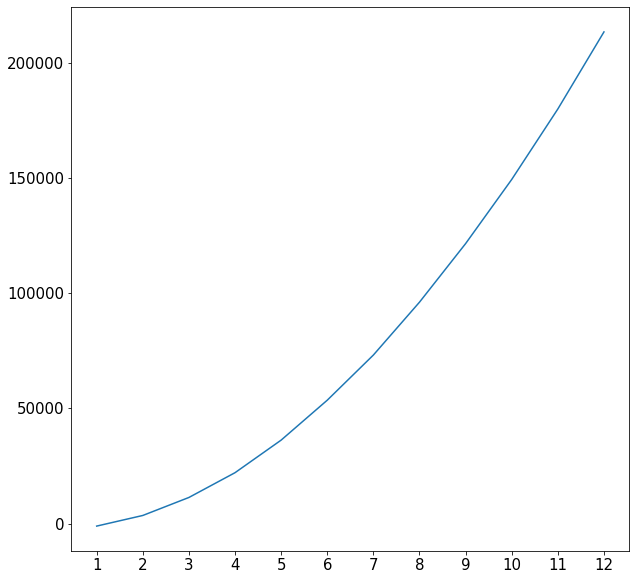

In [13]:
profit_monthly.plot(kind='line', figsize=(10,10), legend=False, fontsize=15, xticks=[i for i in range(1,13)])